In [10]:
### imports

# external modules
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import importlib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model, Sequential, load_model
import importlib
from sklearn.preprocessing import StandardScaler

# local modules
sys.path.append('../utils')
import csv_utils as csvu
import json_utils as jsonu
import dataframe_utils as dfu
import hist_utils as hu
import autoencoder_utils as aeu
import plot_utils as pu
import generate_data_utils as gdu
import refruns_utils as rru
importlib.reload(csvu)
importlib.reload(jsonu)
importlib.reload(dfu)
importlib.reload(hu)
importlib.reload(aeu)
importlib.reload(pu)
importlib.reload(gdu)
importlib.reload(rru)
sys.path.append('../src')
sys.path.append('../src/classifiers')
sys.path.append('../src/cloudfitters')
import HistStruct
importlib.reload(HistStruct)
import SubHistStruct
importlib.reload(SubHistStruct)
import DataLoader
importlib.reload(DataLoader)
import AutoEncoder
importlib.reload(AutoEncoder)
import SeminormalFitter
import GaussianKdeFitter
import HyperRectangleFitter
importlib.reload(SeminormalFitter)
importlib.reload(GaussianKdeFitter)
importlib.reload(HyperRectangleFitter)

<module 'HyperRectangleFitter' from '/eos/home-k/khowey/SWAN_projects/ML4DQMDC-PixelAE/KH-AutoencoderTest/../src/cloudfitters/HyperRectangleFitter.py'>

In [11]:
### Defining bad runs
badruns = {'2017B':
                [
                    297048,
                    297282,
                    297283,
                    297284,
                    297287,
                    297288,
                    297289,
                    299316,
                    299317,
                    299318,
                    299324,
                    299326,
                    301086,
                    301086,
                    303948,
                    297047, #close but, true bad for all 8
                    297169, #true bad for all 8
                    297211, #Reconstructs well
                    299325, #Reconstructs well
                    297664, #true bad for all 8
                    299317, #true bad for all 8
                    297169, #true bad for all 8
                    297502
                ],
             '2017C':[
                  300781, # bad for tracking (pixels were excluded.
                  300079, # is bad for strips and then also for tracking
                  302029, # Poor detector elements for strips - Should be mildly anomalous, but technically good 
                  300576, # Poor detector elements for strips - Should be mildly anomalous, but technically good
                  300574, # Poor detector elements for strips - Should be mildly anomalous, but technically good
                  300282, # Poor detector elements for strips - Should be mildly anomalous, but technically good
                  301912, # Half bad for pixels (lost HV or readout card)  
                  301086, # Half bad for pixels (lost HV or readout card)  
                  300283, # Half bad for pixels (lost HV or readout card) 
                  300282, # Half bad for pixels (lost HV or readout card) 
                  300281, # Half bad for pixels (lost HV or readout card) 
                  300239, # Half bad for pixels (lost HV or readout card)
                  301394, # Marginal for pixels
                  301183, # Marginal for pixels
                  300398, # Marginal for pixels
                  300389, # Marginal for pixels
                  300365  # Marginal for pixels
             ],
             '2017E':[
                 304740, # Bad for pixels and tracking - holes in PXLayer 1
                 304776, # Bad for pixels and tracking - holes in PXLayer 1
                 304506, # Portcard problem for pixels
                 304507, # Portcard problem for pixels 
                 303989, # Bad for pixels, power supply died
                 303824  # Partly bad for strips due to a test
             ],
             '2017F':[
                 306422, # Partly bad for strips - 2 data readouts failed 
                 306423, # Partly bad for strips - 2 data readouts failed
                 306425, # Partly bad for strips - 2 data readouts failed
                 305440, # Partly bad for strips - 1 data readout failed
                 305441, # Partly bad for strips - 1 data readout failed
                 305249, # Bad for pixels - half of disk failed 
                 305250, # Bad for pixels - half of disk failed
                 305064, # Marginal for pixels - some readout failed
             ],
            '2018': # needs to be re-checked, not guaranteed to be fully correct or representative.
                [
                317479,
                317480,
                317481,
                317482,
                319847
                ]}


In [27]:
rundict = jsonu.loadjson('../jsons/CertHelperRefRuns.json')


runNum = 303989
runls = {}
for run in rundict:
    if run['run_number'] == runNum:
        runls.update(run)
if runls == {}:
    raise Exception('Run not found!')

year = runls['dataset'][11:15]
era = runls['dataset'][15]
ref_run = runls['reference_run_number']


outputRuns = {}
outputBad = {}
for run in rundict:
    tempRef = run['reference_run_number']
    if tempRef == ref_run:
        runls = {}
        runls[str(run['run_number'])] = [[-1]]
        if run['run_number'] in badruns[year+era]:
            print('Found bad run :' + str(run))
            outputBad.update(runls)
        else:
            outputRuns.update(runls)

# Perform structuring for compatibility with autoencoders
dataDict = {}
dataDict[year + era] = outputRuns

badrunsls = {}
badrunsls[year + era] = outputBad

trainrunsls = {}
goodrunsls = {}
trainrunsls[year + era] = {}
goodrunsls[year + era] = {}
for i,run in enumerate(dataDict[year + era]):
    if i > 5 and i < 11:
        goodrunsls[year + era][str(run)] = [[-1]]
    else:
        trainrunsls[year + era][str(run)] = [[-1]]

Found bad run :{'run_number': 303824, 'run_reconstruction_type': 'rerecoul', 'reference_run_number': 304158, 'reference_run_reconstruction_type': 'rerecoul', 'dataset': '/ReReco/Run2017E_UL2019/DQM'}
Found bad run :{'run_number': 303989, 'run_reconstruction_type': 'rerecoul', 'reference_run_number': 304158, 'reference_run_reconstruction_type': 'rerecoul', 'dataset': '/ReReco/Run2017E_UL2019/DQM'}
Found bad run :{'run_number': 304740, 'run_reconstruction_type': 'rerecoul', 'reference_run_number': 304158, 'reference_run_reconstruction_type': 'rerecoul', 'dataset': '/ReReco/Run2017E_UL2019/DQM'}


In [28]:
### Data Controls and Selection - 1D Autoncoder

# The directory data is located in
datadir = '../data/'

# Create a list of histograms to include
# Pair histograms to be combined on the same line
histnames = [
    ['NormalizedHitResiduals_TIB__Layer__1', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__1', 'NormalizedHitResiduals_TIB__Layer__2', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__2',
     'NormalizedHitResiduals_TIB__Layer__3', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__3' , 'NormalizedHitResiduals_TIB__Layer__4', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__4'],
    ['chargeInner_PXLayer_1', 'chargeOuter_PXLayer_1', 'adc_PXLayer_1', 'size_PXLayer_1'],
#    ['chargeInner_PXLayer_2', 'chargeOuter_PXLayer_2', 'adc_PXLayer_2', 'size_PXLayer_2'],
#    ['chargeInner_PXLayer_3', 'chargeOuter_PXLayer_3', 'adc_PXLayer_3', 'size_PXLayer_3'],
#    ['chargeInner_PXLayer_4', 'chargeOuter_PXLayer_4', 'adc_PXLayer_4', 'size_PXLayer_4'],
#    ['charge_PXDisk_+1', 'adc_PXDisk_+1'],
#    ['charge_PXDisk_-1', 'adc_PXDisk_-1'],
#    ['charge_PXDisk_+2', 'adc_PXDisk_+2'],
#    ['charge_PXDisk_-2', 'adc_PXDisk_-2'],
#    ['charge_PXDisk_+3', 'adc_PXDisk_+3'],
#    ['charge_PXDisk_-3', 'adc_PXDisk_-3'],
#    ['NormalizedHitResiduals_TOB__Layer__1', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__1', 'NormalizedHitResiduals_TOB__Layer__2', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__2',
#     'NormalizedHitResiduals_TOB__Layer__3', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__3' , 'NormalizedHitResiduals_TOB__Layer__4', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__4']
]


In [29]:
### Model Controls and Selection - 1D Autoencoder

plotNames = 'Test'
name = plotNames+'plots'

# Choose whether to train a new model or load one
trainnew = True
savemodel = True
modelname = plotNames

In [30]:
# train on a user-defined subset of runs
    
# Select runs to be used in training from the user-defined list
runsls_training = trainrunsls[year + era]
# Select bad runs to test on in the user-defined list
runsls_bad = badrunsls[year + era]
# Select good runs to test on in the user-defined list
runsls_good = goodrunsls[year + era]

print('selected runs/lumisections for training: ')
print(runsls_training)
print('selected runs/lumisections as good test set:')
print(runsls_good)
print('selected runs/lumisections as bad test set:')
print(runsls_bad)

selected runs/lumisections for training: 
{'303819': [[-1]], '303999': [[-1]], '304119': [[-1]], '304120': [[-1]], '304197': [[-1]], '304505': [[-1]], '304449': [[-1]], '304452': [[-1]], '304508': [[-1]], '304625': [[-1]], '304655': [[-1]], '304737': [[-1]], '304778': [[-1]], '306459': [[-1]], '304196': [[-1]]}
selected runs/lumisections as good test set:
{'304198': [[-1]], '304199': [[-1]], '304209': [[-1]], '304333': [[-1]], '304446': [[-1]]}
selected runs/lumisections as bad test set:
{'303824': [[-1]], '303989': [[-1]], '304740': [[-1]]}


In [31]:
# Initializations
dloader = DataLoader.DataLoader()
histstruct = SubHistStruct.SubHistStruct()
histstruct.reset_histlist(histnames)

# Unpack histnames and add every histogram individually
for histnamegroup in histnames:
    for histname in histnamegroup:
        print('Adding {}...'.format(histname))
        
        # Bring the histograms into memory from storage for later use
        filename = datadir + year + era + '/DF' + year + era + '_' + histname + '.csv'
        df = dloader.get_dataframe_from_file( filename )
        
        # In case of local training, we can remove most of the histograms
        if( runsls_training is not None and runsls_good is not None and runsls_bad is not None ):
            runsls_total = {k: v for d in (runsls_training, runsls_good, runsls_bad) for k, v in d.items()}
            df = dfu.select_runsls( df, runsls_total )    
            
        # Store the data in the histstruct object managing this whole thing
        histstruct.add_dataframe( df, rebinningfactor = 1, standardbincount = 102 )
print('Found {} histograms'.format(len(histstruct.runnbs)))

Adding NormalizedHitResiduals_TIB__Layer__1...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__1...
Adding NormalizedHitResiduals_TIB__Layer__2...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__2...
Adding NormalizedHitResiduals_TIB__Layer__3...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__3...
Adding NormalizedHitResiduals_TIB__Layer__4...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__4...
Adding chargeInner_PXLayer_1...
Adding chargeOuter_PXLayer_1...
Adding adc_PXLayer_1...
Adding size_PXLayer_1...
Found 9290 histograms


In [32]:
histstruct.add_dcsonjson_mask( 'dcson' )
histstruct.add_goldenjson_mask('golden' )
histstruct.add_highstat_mask( 'highstat' )
histstruct.add_stat_mask( 'lowstat', max_entries_to_bins_ratio=100 )
if runsls_training is not None: histstruct.add_json_mask( 'training', runsls_training )
if runsls_good is not None: histstruct.add_json_mask( 'good', runsls_good )
    
# Distinguishing bad runs
nbadruns = 0
if runsls_bad is not None:
    print(runsls_bad)
    histstruct.add_json_mask( 'bad', runsls_bad )
    
    # Special case for bad runs: add a mask per run (different bad runs have different characteristics)
    nbadruns = len(runsls_bad.keys())
    for i,badrun in enumerate(runsls_bad.keys()):
        histstruct.add_json_mask( 'bad{}'.format(i), {badrun:runsls_bad[badrun]} )

{'303824': [[-1]], '303989': [[-1]], '304740': [[-1]]}


(<Figure size 1440x1080 with 12 Axes>,
 array([[<AxesSubplot:title={'center':'NormalizedHitResiduals\\_TIB\\_\\_Layer\\_\\_1'}>,
         <AxesSubplot:title={'center':'Summary\\_ClusterStoNCorr\\_\\_OnTrack\\_\\_TIB\\_\\_layer\\_\\_1'}>,
         <AxesSubplot:title={'center':'NormalizedHitResiduals\\_TIB\\_\\_Layer\\_\\_2'}>,
         <AxesSubplot:title={'center':'Summary\\_ClusterStoNCorr\\_\\_OnTrack\\_\\_TIB\\_\\_layer\\_\\_2'}>],
        [<AxesSubplot:title={'center':'NormalizedHitResiduals\\_TIB\\_\\_Layer\\_\\_3'}>,
         <AxesSubplot:title={'center':'Summary\\_ClusterStoNCorr\\_\\_OnTrack\\_\\_TIB\\_\\_layer\\_\\_3'}>,
         <AxesSubplot:title={'center':'NormalizedHitResiduals\\_TIB\\_\\_Layer\\_\\_4'}>,
         <AxesSubplot:title={'center':'Summary\\_ClusterStoNCorr\\_\\_OnTrack\\_\\_TIB\\_\\_layer\\_\\_4'}>],
        [<AxesSubplot:title={'center':'chargeInner\\_PXLayer\\_1'}>,
         <AxesSubplot:title={'center':'chargeOuter\\_PXLayer\\_1'}>,
         <AxesSubplot:tit

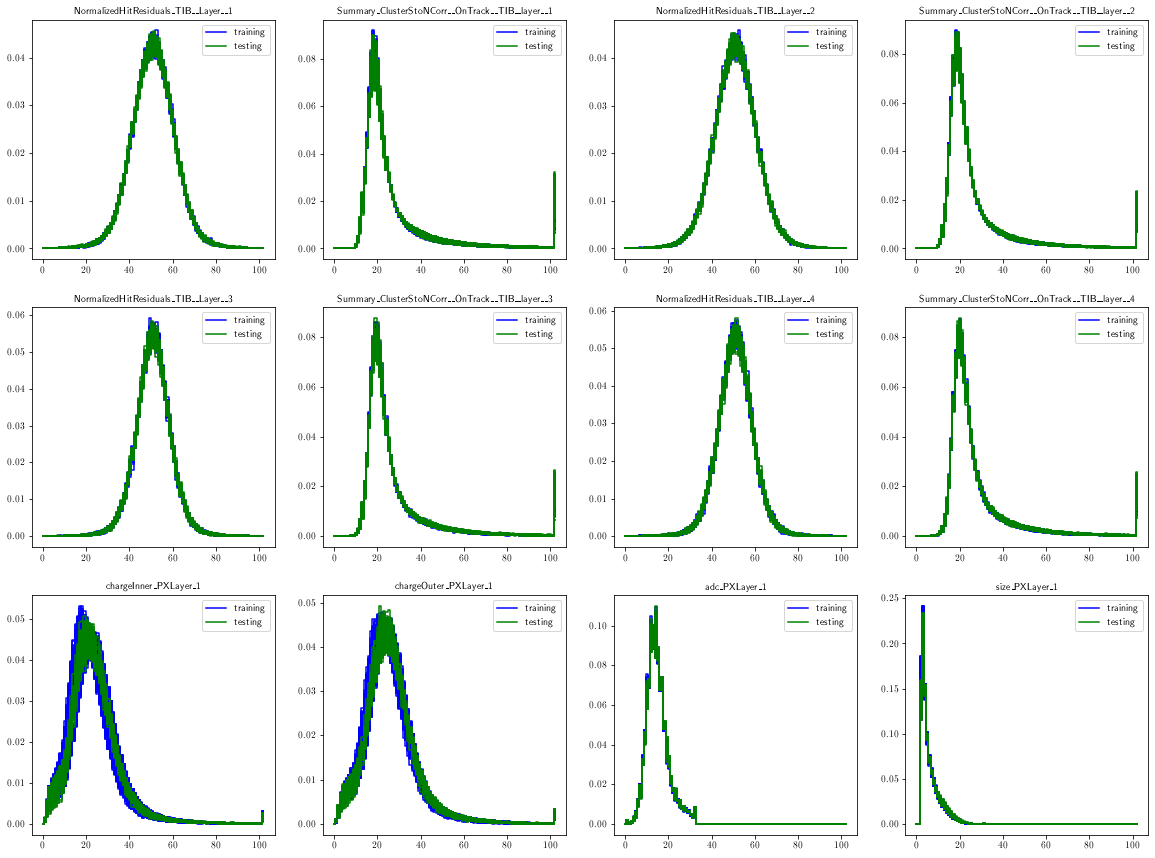

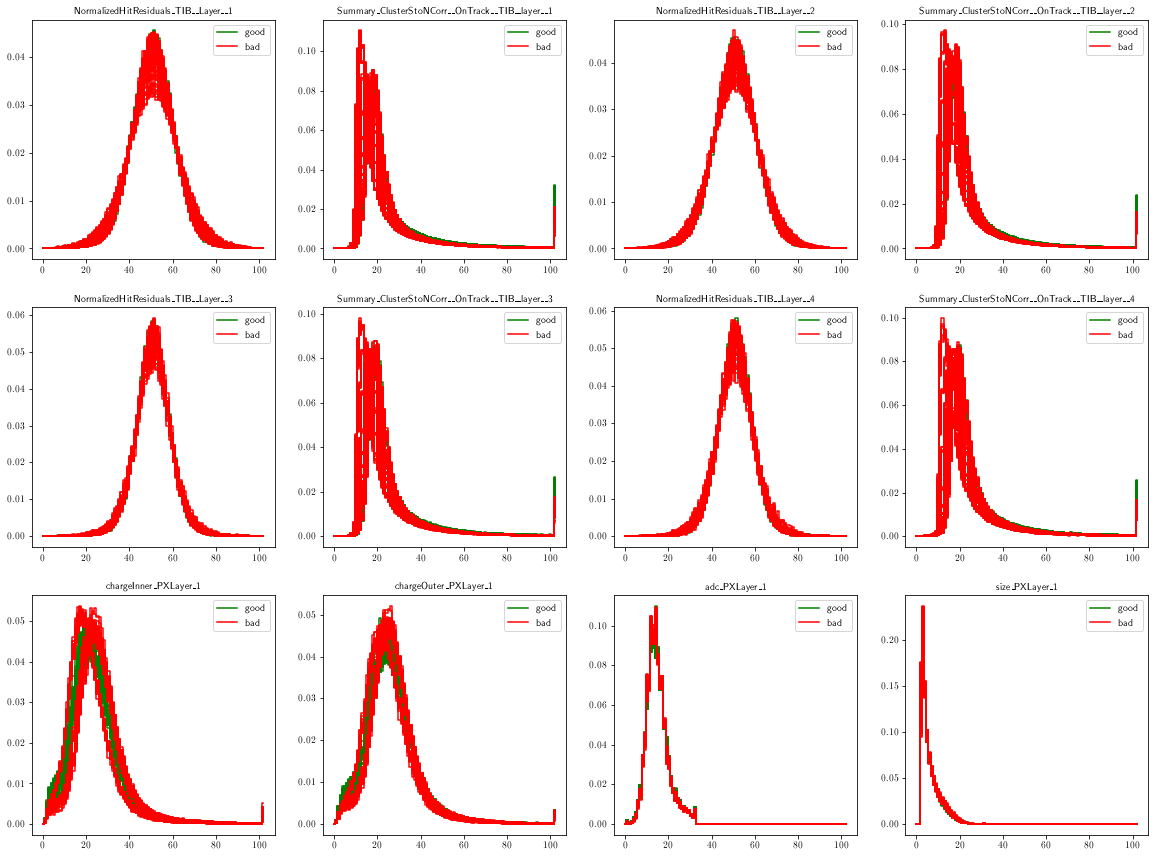

In [33]:
# training and application runs
histstruct.plot_histograms( masknames=[['dcson','highstat','training'],['dcson','highstat','good']],
                            labellist = ['training','testing'],
                            colorlist = ['blue','green']
                          )

# application run and bad test runs
histstruct.plot_histograms( masknames=[['dcson','highstat','good'],['dcson','highstat','bad']],
                            labellist = ['good','bad'],
                            colorlist = ['green','red']
                          )